<h1 style="text-align: center; color: blue;">Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 2)</h1>

<img src="https://github.com/mongolia-newbie/testrepo/blob/main/Screenshot%202021-05-10%20212516.png?raw=true" alt="Chicago Loop">

<h2 style="color:blue;">1. Install Python packages then define some parameters that we will use later.</h2>

In [25]:
! pip install folium==0.5.0
import folium # install plotting library

!pip install geopy
from geopy.geocoders import Nominatim # library for acquiring location geo info

import pandas as pd
import requests
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


<h3>Let's define some parameters like Foursquare client_ID, client_secret, and access_token, etc. (The cell with private account info will be hidden)</h3>

In [26]:
# The code was removed by Watson Studio for sharing.

In [27]:
VERSION = '20210501' # Foursquare version
LIMIT = 100
radius = 600

<h2 style="color:blue;">2. Search and acquire details of cafe stores nearby through Foursquare. Transfer them into Pandas dataframe.</h2>

In [28]:
# Let's find the geo-info of the Chicago city center, which is the city hall, through GeoPy
# The exact address was found on Google.

Chicago_city_hall_address = '121 N LaSalle St, Chicago, IL 60602'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(Chicago_city_hall_address)
lat0 = location.latitude
lng0 = location.longitude
print(lat0, lng0)

41.88341706625744 -87.632303164487


<h3>I will set the search query as 'cafe' and radius as 600. Then get the results with 'requests'.</h3>

In [29]:
search_query = 'cafe'

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat0, lng0, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [30]:
cafe_results = requests.get(url).json()
print('There are', len(cafe_results['response']['venues']), 'cafe stores in the searching result.')

There are 50 cafe stores in the searching result.


<h3>In the course labs, we know the exact path of venue details, I will go ahead and use it. </h3>

In [31]:
cafe_venues = cafe_results['response']['venues']
df_cafe = pd.json_normalize(cafe_venues)
print(df_cafe.shape)
df_cafe.head()

(50, 24)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id
0,5d54c94335b9e6000829a2ce,Hanabusa Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1622017265,False,29 E Madison St,Wabash,41.881831,-87.626545,"[{'label': 'display', 'lat': 41.88183137050559...",...,IL,United States,"[29 E Madison St (Wabash), Chicago, IL 60602]",1961490,https://www.grubhub.com/restaurant/hanabusa-ca...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NaN
1,4ac3492df964a5201f9b20e3,Corner Bakery Cafe,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",v-1622017265,False,"200 N LaSalle St, Ste 100",at Lake St,41.885883,-87.632910,"[{'label': 'display', 'lat': 41.885883, 'lng':...",...,IL,United States,"[200 N LaSalle St, Ste 100 (at Lake St), Chica...",847658,https://www.grubhub.com/restaurant/corner-bake...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NaN
2,4b589a40f964a520ab6028e3,Alonti Café & Catering,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1622017265,False,177 W Washington St,NaN,41.883219,-87.633370,"[{'label': 'display', 'lat': 41.88321872249336...",...,IL,United States,"[177 W Washington St, Chicago, IL 60602]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4b9e3467f964a520afd136e3,Jazzman's Café & Bakery,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1622017265,False,James R. Thompson Center,Concourse Level,41.885042,-87.631631,"[{'label': 'display', 'lat': 41.88504241284185...",...,IL,United States,"[James R. Thompson Center (Concourse Level), C...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4e4c6980bd413c4cc6692d63,Alonti Market Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1622017265,False,330 N Wabash Ave,NaN,41.881320,-87.630132,"[{'label': 'display', 'lat': 41.88132010386988...",...,IL,United States,"[330 N Wabash Ave, Chicago, IL 60611]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3>Let's take a look at what these cafe stores are. </h3>

In [32]:
df_cafe['name']

0                       Hanabusa Cafe
1                  Corner Bakery Cafe
2              Alonti Café & Catering
3             Jazzman's Café & Bakery
4                  Alonti Market Cafe
5                 Madison Street Cafe
6                  Corner Bakery Cafe
7                      Boo & Roo Cafe
8              Chicago Riverwalk Cafe
9           Specialty’s Café & Bakery
10                     Hong Kong Cafe
11                           231 Cafe
12                           Cafe 353
13          Specialty’s Café & Bakery
14            Camille's Sidewalk Cafe
15                           Cafe 300
16             Toni Patisserie & Café
17                   Tower House Cafe
18              Market Creations Cafe
19                        Venice Café
20                        Bombon Cafe
21                 Corner Bakery Cafe
22                        alwood cafe
23                          Stax cafe
24               Eurest Internet Café
25          Sandella's Flatbread Cafe
26          

<H3 style="color:red;">Since there is no Starbucks in the result, I will search with query 'Starbucks' and combine the dataframes together as the final result. Let's do the search, acquire and transfer procedure again.</H3>

In [33]:
search_query_star = 'starbucks'

url_star = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat0, lng0, ACCESS_TOKEN, VERSION, search_query_star, radius, LIMIT)

star_results = requests.get(url_star).json()
print('There are', len(star_results['response']['venues']), 'Starbucks in the searching result.')

There are 40 Starbucks in the searching result.


In [34]:
star_venues = star_results['response']['venues']
df_star = pd.json_normalize(star_venues)
print(df_star.shape)
df_star.head()

(40, 18)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,4bec0a73a9900f4744781840,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1622017266,False,30 N LaSalle St.,41.882818,-87.632493,"[{'label': 'display', 'lat': 41.88281830728615...",68,60602,US,Chicago,IL,United States,"[30 N LaSalle St., Chicago, IL 60602]",NaN,NaN
1,50645e02e4b02acf5a4c218f,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1622017266,False,171 W Randolph St,41.884298,-87.633851,"[{'label': 'display', 'lat': 41.88429836912896...",161,60601,US,Chicago,IL,United States,"[171 W Randolph St, Chicago, IL 60601]",NaN,NaN
2,4b969aa8f964a52006d834e3,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1622017266,False,25 E Washington Blvd,41.883350,-87.627362,"[{'label': 'display', 'lat': 41.88335, 'lng': ...",409,60602,US,Chicago,IL,United States,"[25 E Washington Blvd, Chicago, IL 60602]",NaN,NaN
3,4b38cc49f964a5207e5025e3,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1622017266,False,200 W Madison St,41.882298,-87.634307,"[{'label': 'display', 'lat': 41.88229777, 'lng...",207,60606,US,Chicago,IL,United States,"[200 W Madison St, Chicago, IL 60606]",NaN,NaN
4,4b40d131f964a52088bb25e3,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1622017266,False,200 N Michigan Ave,41.885945,-87.624809,"[{'label': 'display', 'lat': 41.88594506102927...",681,60601,US,Chicago,IL,United States,"[200 N Michigan Ave, Chicago, IL 60601]",NaN,NaN


<h2 style="color:blue;">3. Slice and combine these two dataframes together then group the venues with k-Means clustering. Try to find any patterns based on their geo-info.</h2>

In [35]:
df1 = df_cafe.loc[:,['id','name','location.lat','location.lng']]

df2 = df_star.loc[:,['id','name','location.lat','location.lng']]

df_all = pd.concat([df1, df2], ignore_index=True, sort=False)

print(df_all.shape)
df_all.head()

(90, 4)


,id,name,location.lat,location.lng
0,5d54c94335b9e6000829a2ce,Hanabusa Cafe,41.881831,-87.626545
1,4ac3492df964a5201f9b20e3,Corner Bakery Cafe,41.885883,-87.632910
2,4b589a40f964a520ab6028e3,Alonti Café & Catering,41.883219,-87.633370
3,4b9e3467f964a520afd136e3,Jazzman's Café & Bakery,41.885042,-87.631631
4,4e4c6980bd413c4cc6692d63,Alonti Market Cafe,41.881320,-87.630132


<h3>Let's put them into a scatter plot and have a glance.</h3>

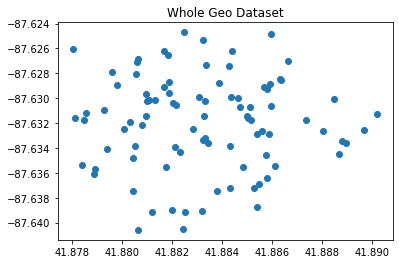

In [36]:
plt.plot()
plt.title('Whole Geo Dataset')
plt.scatter(df_all['location.lat'], df_all['location.lng'])
plt.show()

<h3><u>Elbow Method</u> for optimal value of k in KMeans</h3>

In [37]:
df_geo = df_all.loc[:,['location.lat','location.lng']]

In [38]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df_geo)
    kmeanModel.fit(df_geo)

    distortions.append(sum(np.min(cdist(df_geo, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_geo.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(df_geo, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_geo.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [39]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 0.0019945256491787785
2 : 0.001148909890560701
3 : 0.0007438192863903785
4 : 0.0005509890841647864
5 : 0.0004503975806958421
6 : 0.0003612498918396224
7 : 0.0002976670083406456
8 : 0.00023737669212003622
9 : 0.00020716871116533808


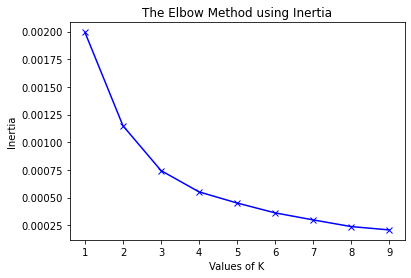

In [40]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Although it's not very obvious, We can still tell that the elbow point would be 4.

In [41]:
# set number of clusters as 4
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_geo)

# insert a new column indication the lable of each store
df_all.insert(0, 'ClusterLabels', kmeans.labels_)
df_all.head()

,ClusterLabels,id,name,location.lat,location.lng
0,2,5d54c94335b9e6000829a2ce,Hanabusa Cafe,41.881831,-87.626545
1,0,4ac3492df964a5201f9b20e3,Corner Bakery Cafe,41.885883,-87.632910
2,1,4b589a40f964a520ab6028e3,Alonti Café & Catering,41.883219,-87.633370
3,0,4b9e3467f964a520afd136e3,Jazzman's Café & Bakery,41.885042,-87.631631
4,2,4e4c6980bd413c4cc6692d63,Alonti Market Cafe,41.881320,-87.630132


<h2 style="color:blue;">4. Visualize all the stores and important spots with Folium.</h2>

<h3>First of all, let's put all the stores and Chicago city hall onto our map.</h3>

In [42]:
# I chose cartodb positron as tiles so we could see the markers clearly.
map_clusters = folium.Map(location=[lat0, lng0], tiles='cartodb positron', zoom_start=15)

folium.CircleMarker(
    [lat0, lng0],
    radius=10,
    color='red',
    popup='Chicago City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.9
).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(df_all['location.lat'], df_all['location.lng'], df_all['name'], df_all['ClusterLabels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

<h3><u>In case you are not able to see the map, I've attached its screenshot below.</u></h3>

<img src="https://github.com/mongolia-newbie/hello-world/blob/master/Venues%20Result.png?raw=true" alt="Venues Result">

<h3>Then, I will add and highlight 4 important subway transfer stations and a Macy's mall. They will be in dark circle. The latitude and longitude numbers are from Google Map. Since we only have a few spots, it's faster to get help from Google directly.</h3>

In [43]:
folium.CircleMarker(
    [41.88262622321891, -87.63385322164534],
    radius=7,
    color='black',
    popup="WashingtonWells",
    fill = False,
).add_to(map_clusters)

In [44]:
folium.CircleMarker(
    [41.884164366621306, -87.6274747952612],
    radius=7,
    color='black',
    popup="Macys",
    fill = False,
).add_to(map_clusters)

In [45]:
folium.CircleMarker(
    [41.88583614810323, -87.62798514756183],
    radius=7,
    color='black',
    popup="StateLake",
    fill = False,
).add_to(map_clusters)

In [46]:
folium.CircleMarker(
    [41.88576015898488, -87.631378990361],
    radius=7,
    color='black',
    popup="ClarkLake",
    fill = False,
).add_to(map_clusters)

In [47]:
folium.CircleMarker(
    [41.880706679766504, -87.62772997141151],
    radius=7,
    color='black',
    popup="Monroe",
    fill = False,
).add_to(map_clusters)

In [48]:
map_clusters

<h3><u>In case you are not able to see the map, I've attached its screenshot below.</u></h3>

 <img src="https://github.com/mongolia-newbie/hello-world/blob/master/Folium%20Done.png?raw=true" alt="Folium Map Done">

***
***

<h3 style="color:blue;">That's it for all the coding sections. As I mentioned in the report, I combined the folium map and the population density screenshot with PhotoShop the app, so that we could give suggestions based on the final output picture (attached below, dots may be in different colors because I ran the codes multiple times.)</h3>

<img src="https://github.com/mongolia-newbie/hello-world/blob/master/Final%20Output%20Picture.png?raw=true" alt="Final Output Picture">